In [1]:
# Useful starting lines
%matplotlib inline

import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the Data
Note that `ratings` is a sparse matrix that in the shape of (num_items, num_users)

In [3]:
from helpers import load_data, preprocess_data

path_dataset = "../data/movielens100k.csv"
ratings = load_data(path_dataset)

number of items: 1682, number of users: 943


### Plot the number of ratings per movie and user

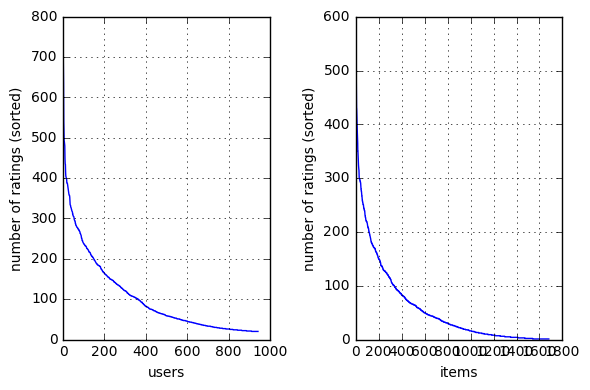

min # of items per user = 20, min # of users per item = 1.


In [4]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

### Split the data into a train and test set

In [6]:
import math

def split_data(ratings, num_items_per_user, num_users_per_item,
               min_num_ratings, p_test=0.1):
    """split the ratings to training data and test data.
    Args:
        min_num_ratings: 
            all users and items we keep must have at least min_num_ratings per user and per item. 
    """
    # set seed
    np.random.seed(988)
    
    # select user and item based on the condition.
    valid_users = np.where(num_items_per_user >= min_num_ratings)[0]
    valid_items = np.where(num_users_per_item >= min_num_ratings)[0]
    valid_ratings = ratings[valid_items, :][: , valid_users]  
    
    I, J, V = sp.find(valid_ratings)
    
    all_indices = np.arange(I.shape[0])
    print(all_indices)
    test_size = math.ceil(I.shape[0]*p_test)
    np.random.shuffle(all_indices)
    test_indices = all_indices[:test_size]
    train_indices = np.delete(all_indices, test_indices, axis=0)

    I_train = I[train_indices]
    J_train = J[train_indices]
    V_train = V[train_indices]
    
    I_test = I[test_indices]
    J_test = J[test_indices]
    V_test = V[test_indices]
    
    test = sp.lil_matrix(sp.coo_matrix((V_test, (I_test, J_test)), (valid_ratings.shape)))
    train = sp.lil_matrix(sp.coo_matrix((V_train, (I_train, J_train)), (valid_ratings.shape)))

    
    # ***************************************************
    # INSERT YOUR CODE HERE
    # split the data and return train and test data. TODO
    # NOTE: we only consider users and movies that have more
    # than 10 ratings
    # ***************************************************
    print("Total number of nonzero elements in origial data:{v}".format(v=ratings.nnz))
    print("Total number of nonzero elements in valid data:{v}".format(v=valid_ratings.nnz))
    print("Total number of nonzero elements in train data:{v}".format(v=train.nnz))
    print("Total number of nonzero elements in test data:{v}".format(v=test.nnz))
    return valid_ratings, train, test

[    0     1     2 ..., 97949 97950 97951]
Total number of nonzero elements in origial data:99999
Total number of nonzero elements in valid data:97952
Total number of nonzero elements in train data:88156
Total number of nonzero elements in test data:9796


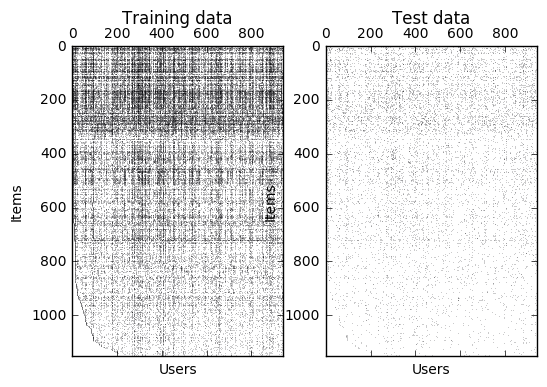

(1152, 943)


In [7]:
from plots import plot_train_test_data

valid_ratings, train, test = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=10, p_test=0.1)
plot_train_test_data(train, test)
print(train.shape)

### Learn the Matrix Factorization using Alternating Least Squares

In [15]:
def init_MF(train, num_features):
    """init the parameter for matrix factorization."""
    Z = 5 * np.random.rand(train.shape[1], num_features) 
    W = np.zeros([train.shape[0], num_features])
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # you should return:
    #     user_features: shape = num_features, num_user
    #     item_features: shape = num_features, num_item
    # ***************************************************
    return W, Z


In [19]:
w, z = init_MF(train, 20)
print(train.shape)
print(w.shape)

(1152, 943)
(1152, 943)
(1152, 20)


In [11]:
A = sp.csr_matrix(train)
A[A > 0] = 1
def update_user_feature(
        train, item_features, lambda_user,
        user_features, num_features):
    """update user feature matrix."""
    for u in range(train.shape[0]):
        d = A[u]
        dense = d.toarray()[0]
        A_i = sp.diags(dense).tocsr()
        #user_features.tolil()
        user_features[u] = sp.linalg.spsolve(item_features.T.dot(A_i.dot(item_features)) +  lambda_user * 
                                             sp.eye(num_features), item_features.T.dot(A_i.dot(train[u].T)))

def update_item_feature(
        train, user_features, lambda_item,
        item_features, num_features):
    """update item feature matrix."""
    for m in range(train.shape[1]):
        d = A.T[m]
        dense = d.toarray()[0]
        A_i = sp.diags(dense).tocsr()
        #user_features.tolil()
        item_features[m] = sp.linalg.spsolve(user_features.T.dot(A_i.dot(user_features)) +  lambda_item * 
                                             sp.eye(num_features), user_features.T.dot(A_i.dot(train[:,m])))

In [12]:
import scipy.sparse.linalg
def get_error(train, W, Z):
    B = sp.csr_matrix(train)
    error_max = W.dot(Z.T)
    #error = train - error_max
    ctrain = sp.coo_matrix(train)
    error = 0
    n = 0
    for i,j,v in zip(ctrain.row, ctrain.col, ctrain.data):
        error += (v - error_max[i, j]) ** 2
        n += 1
    return error/n
    #print(error[(I_train, J_train)])
    #error = error[train > 0].todense() ** 2

In [13]:
from helpers import build_index_groups


def ALS(train, test):
    """Alternating Least Squares (ALS) algorithm."""
    # define parameters
    num_features = 25   # K in the lecture notes
    lambda_user = 0.1
    lambda_item = 0.7
    stop_criterion = 1e-4
    change = 1
    error_list = [0, 0]
    
    # set seed
    np.random.seed(988)

    # init ALS
    user_features, item_features = init_MF(train, num_features)
    for i in range(9):
        print("Iteration ", i)
        update_user_feature(train, item_features, lambda_user, user_features, num_features)
        update_item_feature(train, user_features, lambda_item, item_features, num_features)

    return user_features, item_features

us, it = ALS(train, test)

Iteration  0


/home/michael/dev/tools/anaconda3/lib/python3.5/site-packages/scipy/sparse/compressed.py:730: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Iteration  1
Iteration  2
Iteration  3
Iteration  4
Iteration  5
Iteration  6
Iteration  7
Iteration  8


In [14]:
print(get_error(train, us, it))
print(get_error(test, us, it))

0.264489252344
0.423891897627
